# Waterbody volume estimates from Sentinel 2 and LiDAR <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)



## Description
This notebook demonstrates how to estimate volume by extracting sub-pixel resolution waterlines from Sentinel 2 data based on a water index (MNDWI), and using these waterlines to extract elevations from a LiDAR dataset. 

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import itertools
import datacube
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_spatialtools import subpixel_contours, xr_rasterize


def get_water_level(geom, dem, x_offsets=[0], y_offsets=[0]):  
        
    '''
    Takes a shapely geometry (either LineString or MultiLineString) and a Digital Elevation
    Model (DEM), and samples values from the DEM based on line vertices. These values are used
    to return the median and standard deviation of elevation, which can subsequently be used
    to compute volume (and an estimate of uncertainty) based on the DEM.
    
    Optionally, this function can be run with a set of x and y offset values, which shuffle 
    the geometry object left, right, up and down, and returns values for the combination 
    with the lowest standard deviation. This is intended to account for 'jitter' caused by 
    poor co-registration/georeferencing in the Sentinel 2 imagery. This is experimental, and
    should be used with caution.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    geom : Shapely LineString or MultiLineString
        Shapely geometry for the waterline being analysed
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    x_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry east and west.
        The default is [0], which does no shuffling. E.g. setting `x_offsets=[-10, 0, 10]`
        will shuffle the geometry west and east by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
    y_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry north and south.
        The default is [0], which does no shuffling. E.g. setting `y_offsets=[-10, 0, 10]`
        will shuffle the geometry north and south by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
        
    Returns
    -------
    offset_min_std : Pandas DataFrame
        A Pandas dataframe with columns giving `x_offset', 'y_offset`, `water_level` and 
        `water_level_std` values. `x_offset', 'y_offset` give the offset values which resulted
        in the lowest standard deviation of elevation values, while `water_level` and 
        `water_level_std` return the corresponding median and standard deviation elevation values
        themselves.
    '''
    
    # First try extracting line vertex coordinates from a Shapely LineString
    try: 
        xx, yy = geom.coords.xy
        xx = np.array(xx)
        yy = np.array(yy)

    # If this fails, extract line vertex coordinates as if data is a Shapely MultiLineString
    except:

        xx = np.concatenate([i.coords.xy[0] for i in geom])
        yy = np.concatenate([i.coords.xy[1] for i in geom]) 
        
    # Convert coordinates to xarray DataArrays to facilitate fast extraction of elevation values
    xx = xr.DataArray(xx, dims='z')
    yy = xr.DataArray(yy, dims='z')
    
    # Iterate through all combinations of x and y offsets
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):        

        # Sample DEM to extract elevations for each vertex coordinate
        sampled_elevs = dem.interp(x=xx + x_offset, y=yy + y_offset).values

        # Compute median and standard deviation elevation values, and add to list
        all_offsets.append(((x_offset, y_offset, np.nanmedian(sampled_elevs), np.nanstd(sampled_elevs))))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['x_offset', 'y_offset', 
                                                   'water_level', 'water_level_std'])
    offset_min_std = offset_df.iloc[offset_df.water_level_std.idxmin()]

    return offset_min_std 


def level_to_volume(level_m, dem, resolution, clip_max=True):
    
    '''
    Applies a given water level to a DEM, and computes the total volume
    of the area filled with water in megalitre (Ml) units.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    level_m : int or float
        Water level of dam/reservoir in metre units.
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    resolution : tuple
        A tuple giving the x and y resolutions of the DEM.
    clip_max : bool, optional
        An optional boolean indicating whether to restrict water levels to the highest 
        elevation in the DEM. The default is True, which prevents artificially high
        volumes being computed where water levels are higher than the top of the dam.
        
    Returns
    -------
    total_volume : int or float
        A numeric value giving the computed volume in megalitre (Ml) units
    '''
    
    # If water level is above highest point in DEM, use the highest elevation in 
    # the DEM instead of the supplied water level
    if clip_max:
        level_m = np.min([level_m, dem.max().item()])
        
    # Create a flat array with values set to the given water level
    water_level = np.full(dem.shape[1:], level_m)
    
    # Subtract LiDAR DEM from this water level array to create an array giving the 
    # difference between this water level and the true elevation of each pixel
    water_level_diffs = water_level - dem
    
    # By restricting these differences to only pixels where the water level is
    # higher than the underlying LiDAR DEM (i.e. positive values), we can get
    # depths for every pixel
    water_level_depths = water_level_diffs.where(water_level_diffs > 0)
    
    # By multiplying depths by the area of each pixel (obtained from the resolution
    # of the LiDAR raster), we can compute volumes in cubic metres for each pixel
    water_level_volumes = water_level_depths * (resolution[0] * resolution[1])   
    
    # Finally, sum the volumes of all pixels and multiply by 0.001 to get total 
    # waterbody volume in megaliters (Ml) for the given water level height
    total_volume = water_level_volumes.sum().item() * 0.001

    # Return volume     
    return total_volume


def identify_outliers(data, m = 3):
    
    '''
    Function takes an array of values, and returns a boolean array
    of the same length which flags values as outliers according to the 
    standard deviation m. 
    '''
    
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.
    return s < m

%load_ext autoreload
%autoreload 2


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Waterbody_volumes')

### Analysis parameters

In [3]:
# Input files (LIDAR, waterbody boundary)
waterbody_path = '../Supplementary_data/Waterbody_volumes/waterbody.geojson'
lidar_path = '../Supplementary_data/Waterbody_volumes/lidar_1m.tif'

# Data load and thresholding params
time_period = ('2015-01-01', '2019-03-31')  # Time period to analyse using Sentinel 2A and 2B
min_gooddata = 0.90  # Minimum proportion of cloud free pixels used to return cloud-free images
waterindex_thresh = 0.0  # The threshold to seperate water vs. non water using the MNDWI index

# EXPERIMENTAL: this analysis can be run with a set of x and y offset values, 
# which shuffle the extracted waterline features left, right, up and down, 
# and returns values for the combination with the lowest standard deviation. 
# This is intended to account for 'jitter' caused by poor co-registration/
# georeferencing in the Sentinel 2 imagery. This is experimental, and should be 
# used with caution. Setting offsets to `[0]` is the default; `x_offsets = [-5, 5]`
# will for example shuffle waterlines by 5 pixels left, then 5 pixels right.
x_offsets = [-10, -5, 0, 5, 10]
y_offsets = [-10, -5, 0, 5, 10]
# x_offsets = [0]
# y_offsets = [0]

## Load LiDAR data
Load as an xarray format dataset. The `chunks` option uses dask to break the raster into smaller chunks, and not load any data unless it is requested with `.compute()`. This can be useful for large datasets like high-res LiDAR data, which will cause memory issues and run very slowly if loaded all in one go.

In [4]:
lidar_data = xr.open_rasterio(lidar_path, chunks={'x': 3000, 'y': 3000})
lidar_data = lidar_data.squeeze('band').drop('band')
lidar_data

<xarray.DataArray (y: 6271, x: 9982)>
dask.array<getitem, shape=(6271, 9982), dtype=float32, chunksize=(3000, 3000), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 6.65e+06 6.65e+06 6.65e+06 ... 6.644e+06 6.644e+06
  * x        (x) float64 7.52e+05 7.52e+05 7.52e+05 ... 7.62e+05 7.62e+05
Attributes:
    transform:      (1.0000228010418855, 0.0, 752023.499, 0.0, -0.99998191675...
    crs:            +init=epsg:28355
    res:            (1.0000228010418855, 0.999981916759664)
    is_tiled:       0
    nodatavals:     (-3.4028230607370965e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

## Load extent polygon

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


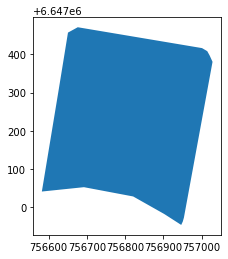

In [5]:
polygon_gdf = gpd.read_file(waterbody_path)

# Convert to same projection system as DEM
polygon_gdf = polygon_gdf.to_crs(crs=lidar_data.crs)
polygon_gdf.plot()

## Clip and mask LiDAR to extent of polygon

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


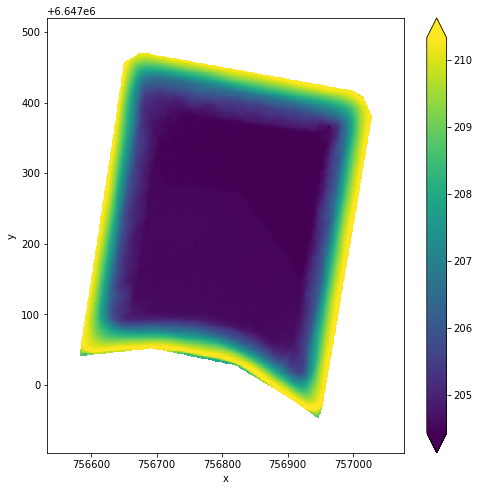

In [6]:
# Clip LiDAR dataset to the extent of the waterbody polygon, buffered by X m
buffer = 50
minx, miny, maxx, maxy = polygon_gdf.buffer(buffer).bounds.values.T
lidar_subset = lidar_data.isel(x = (lidar_data.x > minx) & (lidar_data.x < maxx),
                               y = (lidar_data.y > miny) & (lidar_data.y < maxy))

# Generate mask from shapefile
xarray_mask = xr_rasterize(gdf=polygon_gdf, da=lidar_subset)

# Load data into memory using `.compute()`
lidar_subset = lidar_subset.compute()

# Create new DEM which is masked to restrict data to waterbody extent
lidar_masked = lidar_subset.where(xarray_mask)
lidar_masked.plot(figsize=(8,8), robust=True)

## Load in Sentinel 2 data
Loads in time series data from Sentinel 2A and 2B, compute a water index (Modified Normalised Difference Water Index or MNDWI), and drop obvious outliers with significantly more water pixels than other time steps (this is often caused by incorrectly masked cloud).

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 189 out of 274 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 189 time steps


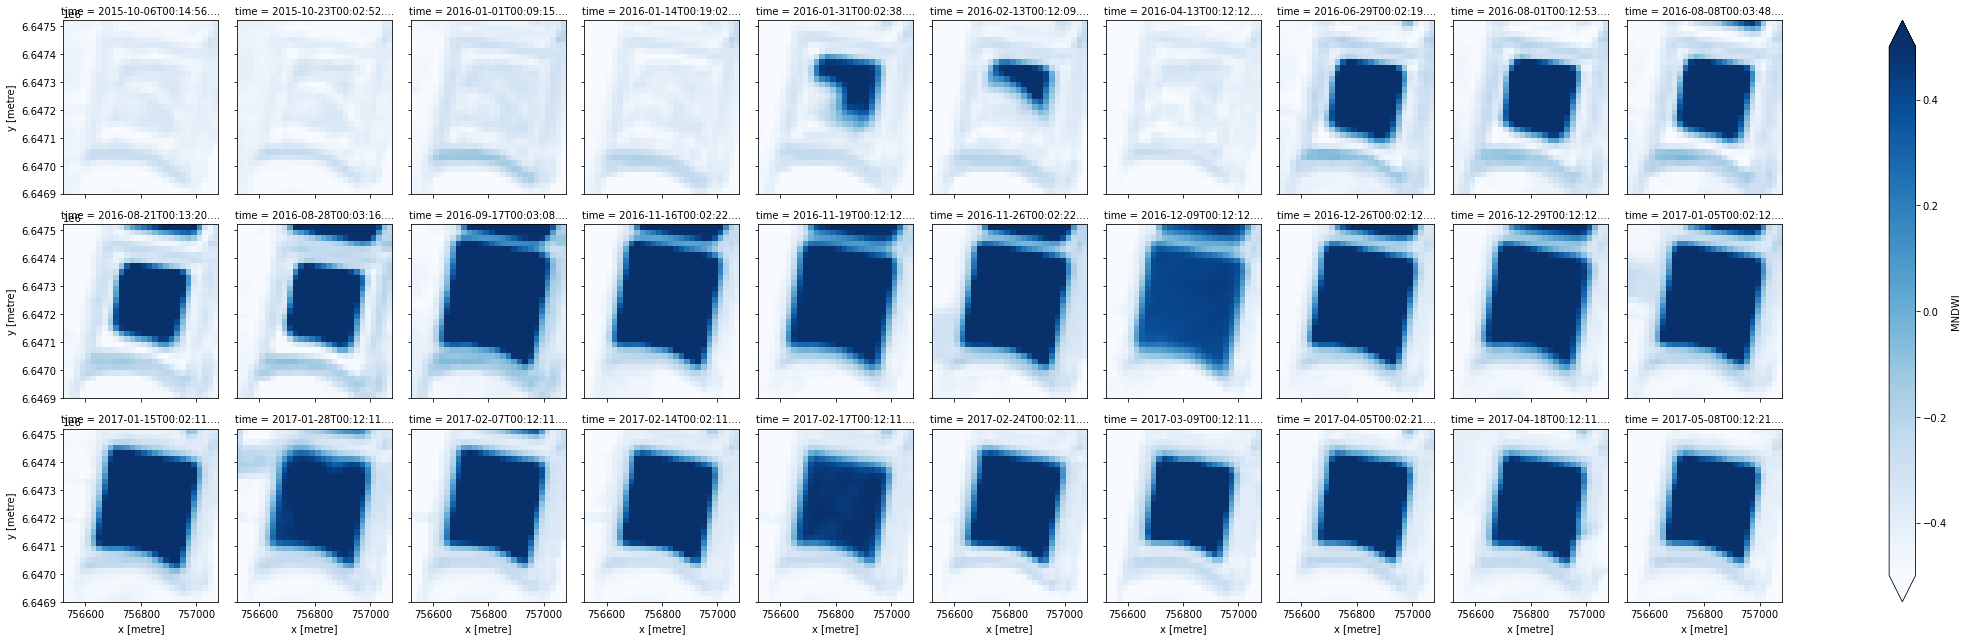

In [7]:
# Get spatial extent bounds from dimensions of LiDAR data
query = {
    'geopolygon': lidar_subset.geobox.extent,
    'time': time_period,
}

# Load in only Sentinel 2 observations with less than X percent clear pixels
satellite_ds = load_ard(dc=dc, 
                        products=['s2a_ard_granule', 's2b_ard_granule'],
                        min_gooddata=min_gooddata,
                        measurements = ['nbart_green', 'nbart_swir_2'],
                        resolution = (-20, 20),
                        output_crs = lidar_data.crs,
                        resampling = {'fmask': 'nearest', '*': 'average'},
                        **query)

# Compute Modified Normalised Difference Water Index (MNDWI)
satellite_ds = calculate_indices(satellite_ds, 
                                 index='MNDWI', 
                                 collection='ga_s2_1')

# Drop outliers caused by unflagged cloud (i.e. any timestep 3 standard 
# deviations above the median water pixels AND > 50% water pixels)
water_prop = (satellite_ds.MNDWI > 0).mean(dim = ['x', 'y'])
outliers_bool = identify_outliers(water_prop, m = 3)
satellite_ds = satellite_ds.sel(time = outliers_bool | (water_prop < 0.5))

# Preview results for the first 30 observations
satellite_ds.MNDWI.isel(time=slice(0, 30)).plot.imshow(col='time',
                                                       col_wrap=10,
                                                       vmin=-0.5, 
                                                       vmax=0.5,
                                                       cmap='Blues',
                                                       add_labels=False)

## Extract waterline boundaries
This uses sub-pixel resolution contour extraction ([Bishop-Taylor et al. 2019](https://doi.org/10.3390/rs11242984)) to extract the boundary between land and water for each time step in the dataset, and returns a shapefile of waterlines.

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


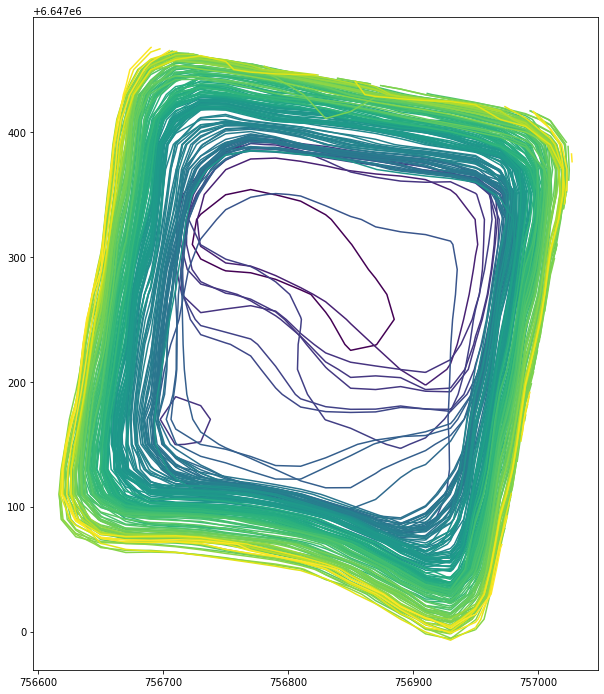

In [8]:
# Calculate area per timestep to add as an attribute to each waterline
res = satellite_ds.geobox.resolution[1]
area_da = (satellite_ds.MNDWI > waterindex_thresh).sum(dim=['x', 'y']) * res ** 2
area_df = area_da.drop('spatial_ref').to_dataframe('area')

# Extract waterline contours for the supplied water index threshold:
contour_gdf = subpixel_contours(da=satellite_ds.MNDWI,                               
                                z_values=[waterindex_thresh],
                                crs=satellite_ds.crs,
                                affine=satellite_ds.geobox.transform,
                                attribute_df=area_df)

# Clip contours to extent of waterbody polygon. This prevents the waterlines 
# including portions of neighbouring waterbodies or surrounding naturally wet
# terrain, which would introduce uncertainty into extracted water level estimates.
# Because this may delete some contours entirely, we then filter to keep only
# contours that have data after the clip.
contour_gdf['geometry'] = contour_gdf.intersection(polygon_gdf.unary_union)
contour_gdf = contour_gdf[[True if i else False for i in contour_gdf.geometry]]
contour_gdf.sort_values('area').plot(figsize=(12, 12), column='area')

## Extract median and standard deviation water levels from LiDAR
Sentinel 2 imagery can be affected by 'jitter' caused by poor co-registration/georeferencing which can offset imagery by > 10m in the x and y directions. The steps below can be run with a set of x and y offset values, which shuffle the geometry object left, right, up and down, and returns values for the combination of offsets with the lowest standard deviation. This is intended to optimise the location for each waterline by finding the location which most closely follows the shape of the actual terrain. This can greatly improve results, but is **experimental** and should be used with caution.

In [9]:
# Convert pandas dataframe to dask dataframe
contour_dd = dd.from_pandas(contour_gdf, npartitions=8)

# Apply get_water_level to each partition, parallelising across cores
extracted_waterlevels = (contour_dd.map_partitions(
    lambda df: df.apply(lambda x: get_water_level(geom=x.geometry,
                                                  dem=lidar_subset,
                                                  x_offsets=x_offsets,
                                                  y_offsets=y_offsets), axis=1),
    meta=[('x_offset', 'i8'), ('y_offset', 'i8'), ('water_level', 'f8'),
          ('water_level_std', 'f8')]).compute(scheduler='processes'))

# Put back into contour dataframe
contour_gdf[['x_offset', 'y_offset', 'water_level', 'water_level_std']] = extracted_waterlevels
contour_gdf.head()


,time,area,geometry,x_offset,y_offset,water_level,water_level_std
time,,,,,,,
2016-01-31 00:02:38.456,2016-01-31,39200.0,"LINESTRING (756890.000 6647146.742, 756878.585...",-10.0,-10.0,204.510456,0.126319
2016-02-13 00:12:09.456,2016-02-13,24800.0,"LINESTRING (756910.000 6647197.377, 756890.000...",-5.0,-5.0,204.458073,0.025583
2016-06-29 00:02:19.460,2016-06-29,68400.0,"LINESTRING (756910.000 6647085.475, 756890.000...",-10.0,5.0,204.583539,0.268780
2016-08-01 00:12:53.537,2016-08-01,66800.0,"LINESTRING (756890.000 6647085.729, 756870.000...",-10.0,0.0,204.564830,0.254071
2016-08-08 00:03:48.043,2016-08-08,70800.0,"LINESTRING (756910.000 6647086.517, 756890.000...",-10.0,5.0,204.579975,0.270795


## Convert water levels to volumes for each timestep

In [10]:
# Get volume from heights
res = lidar_data.res
contour_gdf['volume'] = contour_gdf.apply(lambda x: level_to_volume(
    level_m=x.water_level, dem=lidar_masked, resolution=res),
                                          axis=1)
contour_gdf['volume_min'] = contour_gdf.apply(lambda x: level_to_volume(
    level_m=x.water_level - x.water_level_std, dem=lidar_masked, resolution=res
),
                                              axis=1)
contour_gdf['volume_max'] = contour_gdf.apply(lambda x: level_to_volume(
    level_m=x.water_level + x.water_level_std, dem=lidar_masked, resolution=res
),
                                              axis=1)

# Add missing 0 volume timesteps by comparing set of dates in the contour file to dates in original data
missing_dates = set(str(i)[0:10] for i in satellite_ds.time.values) - set(
    contour_gdf.time)
missing_data = pd.DataFrame(np.zeros(shape=(len(missing_dates), 3)),
                            index=missing_dates,
                            columns=['volume', 'volume_min', 'volume_max'])
contour_gdf = pd.concat([contour_gdf.set_index('time'), missing_data],
                        sort=False).sort_index()

# Drop any 0 volume timestep that is completely surrounded by two timesteps with volumes > the lowest 10%
# of all volumes. The observations are likely to be invalid (e.g. water obscured by unmasked cloud etc)
shifted_test = ((contour_gdf.volume.shift(1, fill_value=1) >
                 contour_gdf.volume.quantile(0.1)) & (contour_gdf.volume.shift(
                     -1, fill_value=1) > contour_gdf.volume.quantile(0.1)))
contour_gdf = contour_gdf[~((contour_gdf.volume == 0) & shifted_test)]

# Make dataframe index time-aware
contour_gdf.index = pd.DatetimeIndex(contour_gdf.index)
contour_gdf.head()

,area,geometry,x_offset,y_offset,water_level,water_level_std,volume,volume_min,volume_max
2015-10-06,NaN,None,NaN,NaN,NaN,NaN,0.00000,0.00000,0.000000
2015-10-23,NaN,None,NaN,NaN,NaN,NaN,0.00000,0.00000,0.000000
2016-01-01,NaN,None,NaN,NaN,NaN,NaN,0.00000,0.00000,0.000000
2016-01-14,NaN,None,NaN,NaN,NaN,NaN,0.00000,0.00000,0.000000
2016-01-31,39200.0,"LINESTRING (756890.000 6647146.742, 756878.585...",-10.0,-10.0,204.510456,0.126319,1.79028,0.00002,9.618763


## Plot volume time series

Average standard deviation of water level: 0.56 m



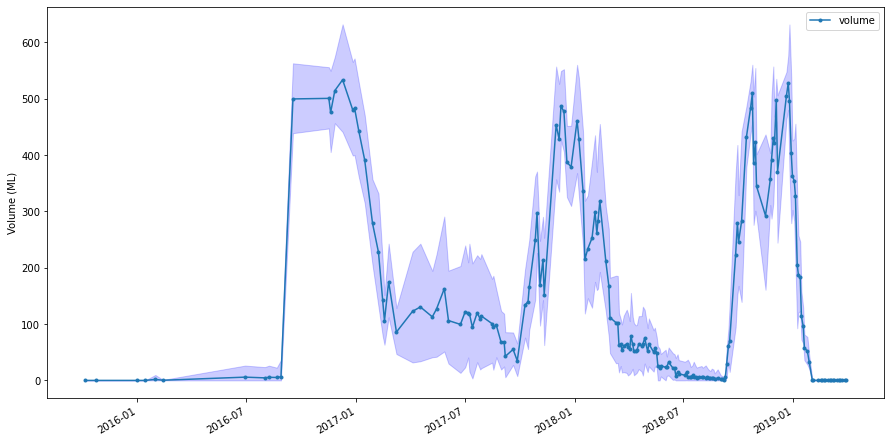

In [11]:
contour_gdf[['volume']].plot(figsize=(15, 8), style='-o', ms=3)
plt.gca().set_ylabel("Volume (ML)")
plt.fill_between(contour_gdf.index, contour_gdf.volume_min, contour_gdf.volume_max, color='b', alpha=0.2)
print(f'Average standard deviation of water level: {contour_gdf.water_level_std.mean():.{2}f} m\n')

## Plot waterline contours coloured by volume

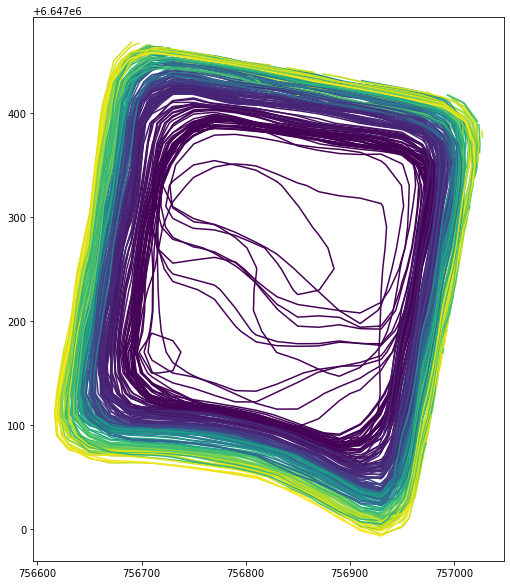

In [12]:
contour_gdf.plot(figsize=(10, 10), column='volume')

## Plot area-volume relationship

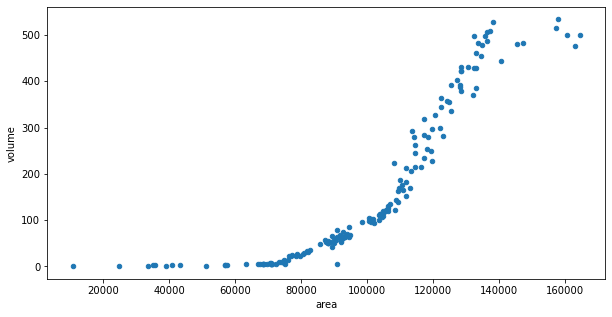

In [13]:
contour_gdf[['area', 'volume']].plot.scatter(x='area', 
                                             y='volume', 
                                             figsize=(10, 5))

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2021

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.3
